In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [62]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')

from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import numpy as np

from eden.util import fit_estimator,fit , random_bipartition_iter,estimate
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vectorizer = Vectorizer( complexity=2 )
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################
from eden.util import iterator_size 
from time import time
def train_estimator_and_evaluate_testsets(pos_original,neg_original,pos_augmented,neg_augmented,pos_test,neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = itertools.tee(pos_original)
    neg_orig,neg_orig_ = itertools.tee(neg_original)
    
    pos_augmented , pos_sampled = itertools.tee(pos_augmented)
    neg_augmented , neg_sampled = itertools.tee(neg_augmented)
    
    pos_augmented = itertools.chain(pos_augmented,pos_orig_)
    neg_augmented = itertools.chain(neg_augmented,neg_orig_)

    predictive_performances=[]
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),( 'original+sample',pos_augmented, neg_augmented),('sample',pos_sampled,neg_sampled)]:
        pos_train,pos_train_=itertools.tee(pos_train)
        neg_train,neg_train_=itertools.tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        start=time()
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
        pos_test,pos_test_=itertools.tee(pos_test)
        neg_test,neg_test_=itertools.tee(neg_test)
        local_estimator=fit(pos_train,neg_train,vectorizer,n_jobs=-1)
        predictive_performances.append(estimate(pos_test_,neg_test_,local_estimator,vectorizer)[1])
        print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances


def sample(graphs):
    sampler =GraphLearnSampler(radius_list=[1,2],thickness_list=[1,2])
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs, n_jobs=-1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
    n_steps=20
    sampling_factor=3 #how many samples per seed
    
    sampling_interval=np.ceil([n_steps/sampling_factor])
    graphs = sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=True,
                        select_cip_max_tries=200,
                        batch_size=30,
                        n_steps=n_steps,
                        sampling_interval=sampling_interval,
                        n_jobs=-1,
                        annealing_factor=1.0,
                        probabilistic_core_choice=True)
    for graph in list(graphs):
        path_graphs = graph.graph['sampling_info']['graphs_history']
        for path_graph in path_graphs:
            yield path_graph

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
%time
from time import time
# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
originals=[]
improved=[]
only_new=[]

percentages=[.1, .25,.5,.75,.9]
for percentage in percentages:
    ######### first we generate all the iterators ###########
    # copy the mega set
    graphs_pos, graphs_pos_ = itertools.tee(graphs_pos,2)
    graphs_neg, graphs_neg_ = itertools.tee(graphs_neg,2)


    # use shuffled list to create test and sample set
    pos,pos_test = random_bipartition_iter(graphs_pos_,0.6 * percentage)
    pos,pos_= itertools.tee(pos)
    neg,neg_test = random_bipartition_iter(graphs_neg_,0.6 * percentage)
    neg,neg_= itertools.tee(neg)
 
    ############### then we sample #####################
    sampled_neg= sample(neg)
    sampled_pos= sample(pos)
    
    
    ######### and last we evaluate ###########
    start=time()
    print "="*80
    print "training percentage:"+str(percentage)
    aug,ori,new=train_estimator_and_evaluate_testsets( pos_,neg_,sampled_pos, sampled_neg, pos_test,neg_test)
    improved.append(aug)
    originals.append(ori)
    only_new.append(new)
    print 'elapsed: %.1f sec'%(time()-start)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
training percentage:0.1
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 144 #neg: 116
Test set
Instances: 4077 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.72      0.69      0.70      1820
          1       0.76      0.78      0.77      2257

avg / total       0.74      0.74      0.74      4077

APR: 0.840
ROC: 0.821
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 858 #neg: 687
Test set
Instances: 4077 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    

original+sample: [0.8273647808130602, 0.85168393575173473, 0.88300889626117796, 0.89935046048202794, 0.88881190009816313, 0.88541906130268166]
original: [0.82291162860127898, 0.84608308065935123, 0.87192611813165755, 0.87872385716906454, 0.88753048089863973, 0.85750718390804648]
sample: [0.81981763447280953, 0.84106552072653906, 0.86357544894131, 0.87105544258629064, 0.86569638582044228, 0.8633979885057449]


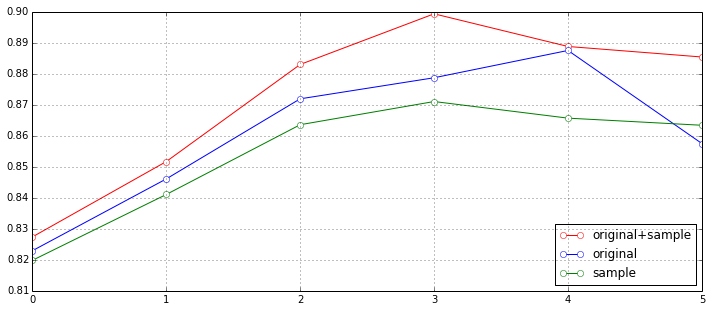

In [60]:
#print 'original+sample:',improved
#print 'original:',originals
#print 'sample:',only_new

# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(improved, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(only_new, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('results.pdf')

original+sample: [0.8273647808130602, 0.85168393575173473, 0.88300889626117796, 0.89935046048202794, 0.88881190009816313, 0.88541906130268166]
original: [0.82291162860127898, 0.84608308065935123, 0.87192611813165755, 0.87872385716906454, 0.88753048089863973, 0.85750718390804648]
sample: [0.81981763447280953, 0.84106552072653906, 0.86357544894131, 0.87105544258629064, 0.86569638582044228, 0.8633979885057449]


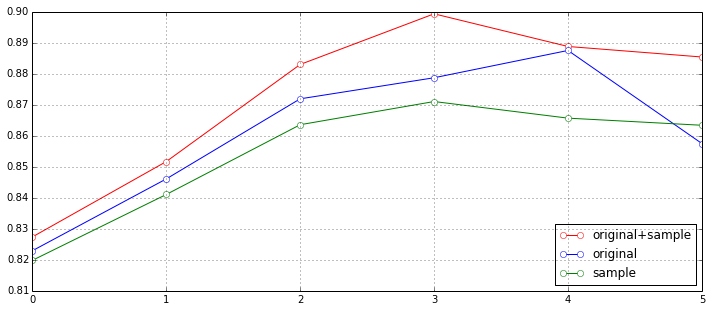

In [60]:
#print 'original+sample:',improved
#print 'original:',originals
#print 'sample:',only_new

# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(improved, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(only_new, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('results.pdf')